In [1]:
__author__ = 'Erwin Chen'
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as stats
from sklearn.covariance import EmpiricalCovariance, MinCovDet, EllipticEnvelope

In [2]:
from astropy.io import fits
from astropy.table import Table, join

# load Cannon data
ap_file = fits.open('results-unregularized-matched.fits')
# print (ap_file[1].header.keys)
ap_data = ap_file[1].data
feature_names = ['APOGEE_ID', 'GLON', 'GLAT', 'RA', 'DEC', 'VHELIO_AVG', 'LOGG', 'TEFF', 'PMRA', 'PMDEC', 
                 'AL_H', 'CA_H', 'C_H','FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H',
                 'S_H', 'TI_H', 'V_H', 'SNR', 'H', 'J', 'K']
element_names = ['AL_H', 'CA_H', 'C_H', 'FE_H', 'K_H', 'MG_H', 'MN_H', 'NA_H', 'NI_H', 'N_H', 'O_H', 'SI_H', 'S_H', 'TI_H', 'V_H']
ap_cols = []
for name in feature_names:
    ap_cols.append(ap_data.field(name))
ap_cols = np.array(ap_cols)
ap_cols = ap_cols.T
dtype = ['float' for n in range(len(feature_names))]
dtype[0] = 'string'
ap_table = Table(data=ap_cols, names=feature_names, dtype=dtype)

In [3]:
# add membership
known_clusters = np.loadtxt('table4.dat', usecols=(0, 1), dtype=('S', 'S'), unpack=True)
member_IDs = known_clusters[0]
member_names = known_clusters[1]
names = ['APOGEE_ID', 'cluster_name']
dtype=['string', 'string']
member_table = Table(data=[member_IDs, member_names], names=names, dtype=dtype)
ap_table = join(ap_table, member_table, keys='APOGEE_ID', join_type='left')
cluster_names = list(set(member_names))

In [4]:
ap_table['cluster_name'].fill_value = 'background'
ap_table = ap_table.filled()

In [5]:
# indexes of stars with full chemical abundances
index_chem = np.arange(len(ap_table))
for name in element_names:
    index_chem = np.intersect1d(index_chem, np.where(ap_table[name] > -9999.)[0])
# indexes of members 
index_member = np.where(ap_table['cluster_name'] != 'background')[0]
# indexes of members with full chemical abundances
index_m_c = np.intersect1d(index_member, index_chem)

/usr/users/bchen/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in greater


In [6]:
ap_table = ap_table[index_chem]
ap_table = ap_table.group_by('cluster_name')

In [7]:
error_features = ['%s_ERR'%element for element in element_names]
error_features.insert(0, 'APOGEE_ID')
error_cols = []
for name in error_features:
    error_cols.append(ap_data.field(name))
error_cols = np.array(error_cols)
error_cols = error_cols.T
dtype = ['float' for n in range(len(error_features))]
dtype[0] = 'string'
err_table = Table(data=error_cols, names=error_features, dtype=dtype)
ap_table = join(ap_table, err_table, keys='APOGEE_ID', join_type='left')

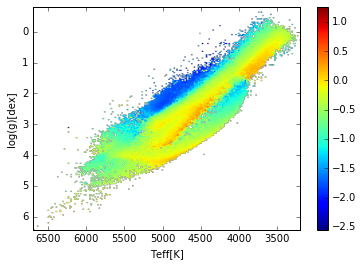

In [8]:
from scipy import stats

ret = stats.binned_statistic_2d(ap_table['TEFF'], ap_table['LOGG'], values=ap_table['FE_H'], 
                                statistic='mean', bins=200)
extent = [ret[1][-1], ret[1][0], ret[2][-1], ret[2][0]]
plt.imshow(np.rot90(ret.statistic, 3), extent=extent, aspect='auto')
plt.xlabel('Teff[K]')
plt.ylabel('log(g)[dex]')
plt.colorbar()
plt.savefig("H_R_Fe.pdf")
plt.show()

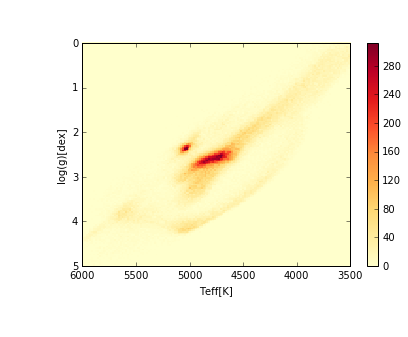

In [78]:
plt.hist2d(ap_table['TEFF'], ap_table['LOGG'], bins=200, cmap='YlOrRd')
plt.xlabel('Teff[K]')
plt.ylabel('log(g)[dex]')
plt.colorbar()
plt.xlim(6000, 3500)
plt.ylim(5,0)
plt.savefig("H_R_all_stars.pdf")
plt.show()

## Spectral H-R diagram

In [10]:
colors = ['b', 'r', 'c', 'y', 'm', 'g', 'pink', 'orange', 'gold', 
          'tan', 'lime', 'teal', 'purple']

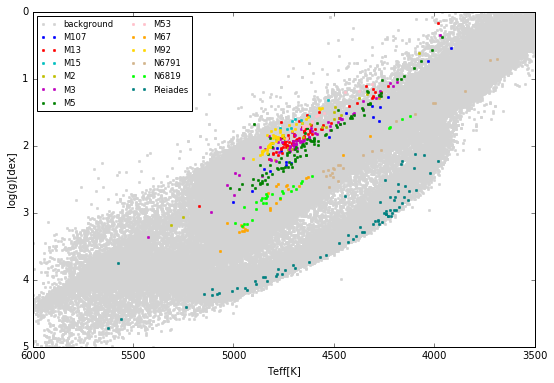

In [81]:
ap_table = ap_table.group_by('cluster_name')
k = 0
fig = plt.figure(figsize=(9,6))
plt.plot(ap_table['TEFF'], ap_table['LOGG'], '.', c='lightgray', ms=5, label='background')
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        plt.plot(group['TEFF'], group['LOGG'], '.', c=colors[k], 
                 lw=0, markersize=5, label=group['cluster_name'][0])
        k += 1
plt.xlabel('Teff[K]')
plt.ylabel('log(g)[dex]')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.xlim(6000, 3500)
plt.ylim(5,0)
plt.legend(loc=0, ncol=2, fontsize='small')
plt.savefig("H_R_all_members.png", dpi=500)
plt.show()


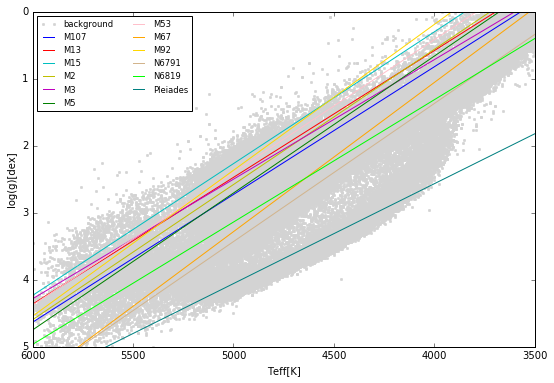

In [12]:
k = 0
fig = plt.figure(figsize=(9,6))
plt.plot(ap_table['TEFF'], ap_table['LOGG'], '.', c='lightgray', ms=5, label='background')
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        coeff = np.polyfit(group['TEFF'], group['LOGG'], deg=1)
        poly = np.poly1d(coeff)
        xp = np.linspace(3500, 6000, 1000)
        plt.plot(xp, poly(xp), '-', c=colors[k], markersize=5, label=group['cluster_name'][0])
        k += 1
plt.xlabel('Teff[K]')
plt.ylabel('log(g)[dex]')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.title("First-Order Approximation")
plt.xlim(6000, 3500)
plt.ylim(5,0)
plt.legend(loc=0, ncol=2, fontsize='small')
plt.savefig("H_R_FO.png", dpi=500)
plt.show()

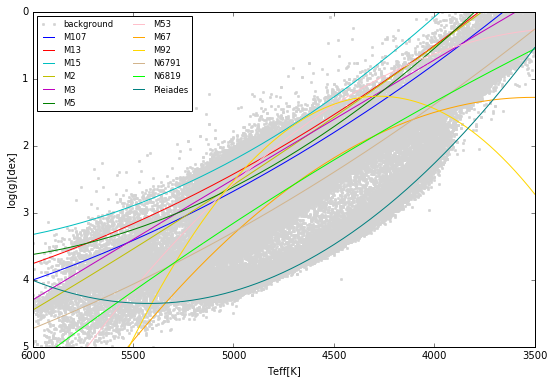

In [13]:
k = 0
fig = plt.figure(figsize=(9,6))
plt.plot(ap_table['TEFF'], ap_table['LOGG'], '.', c='lightgray', ms=5, label='background')
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        coeff = np.polyfit(group['TEFF'], group['LOGG'], deg=2)
        poly = np.poly1d(coeff)
        xp = np.linspace(3500, 6000, 1000)
        plt.plot(xp, poly(xp), '-', c=colors[k], markersize=5, label=group['cluster_name'][0])
        k += 1
plt.xlabel('Teff[K]')
plt.ylabel('log(g)[dex]')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.title("Second-Order Approximation")
plt.xlim(6000, 3500)
plt.ylim(5,0)
plt.legend(loc=0, ncol=2, fontsize='small')
plt.savefig("H_R_SO.png", dpi=500)
plt.show()

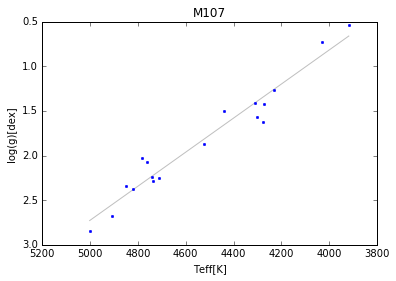

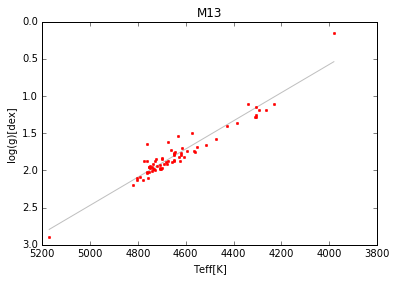

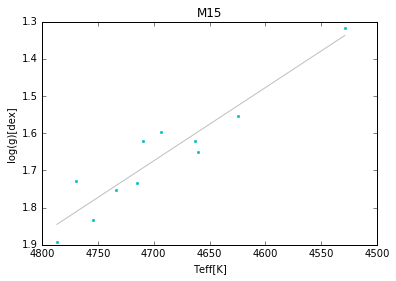

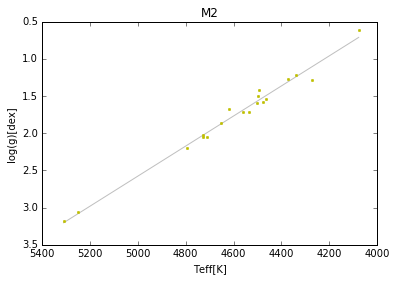

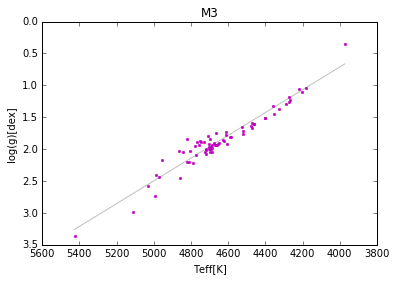

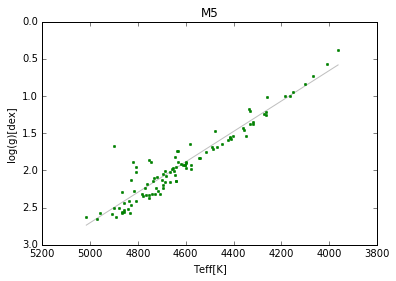

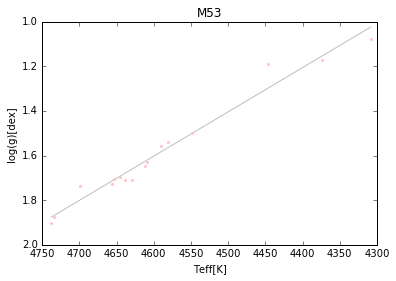

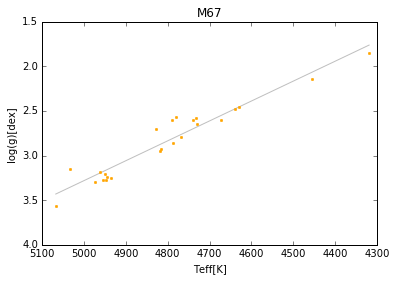

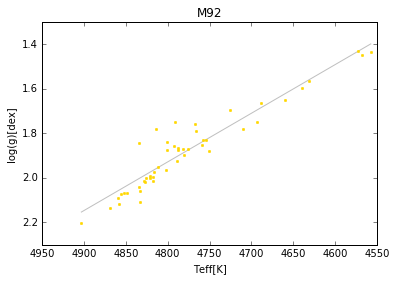

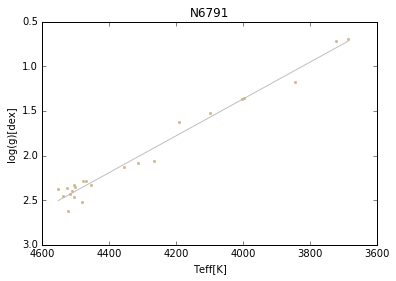

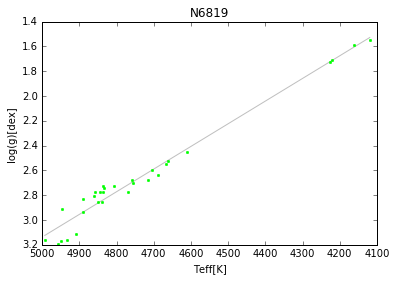

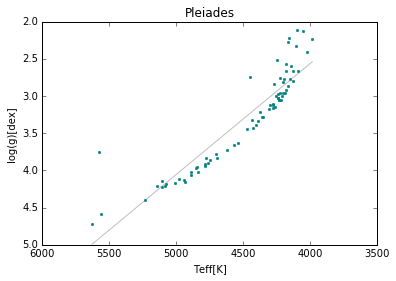

In [115]:
k = 0
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        fig = plt.figure()
        coeff = np.polyfit(group['TEFF'], group['LOGG'], deg=1)
        poly = np.poly1d(coeff)
        xp = np.linspace(np.amin(group['TEFF']), np.amax(group['TEFF']), 100)
        plt.plot(xp, poly(xp), '-', c='grey', alpha=0.5)
        plt.plot(group['TEFF'], group['LOGG'], '.', c=colors[k], 
                 lw=0, markersize=5)
        k += 1
        plt.gca().invert_yaxis()
        plt.gca().invert_xaxis()
        plt.title(group['cluster_name'][0])
        plt.xlabel('Teff[K]')
        plt.ylabel('log(g)[dex]')
        plt.show()

## Color-Magnitude Diagram

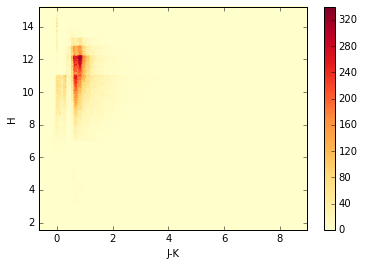

In [77]:
fig = plt.figure()
valid = np.where((ap_table['J']-ap_table['K'] < 99))[0]
plt.hist2d(ap_table['J'][valid]-ap_table['K'][valid], ap_table['H'][valid], 
           bins=200, cmap='YlOrRd')
plt.xlabel('J-K')
plt.ylabel('H')
plt.colorbar()
plt.savefig("C_M_all_stars.pdf")
plt.show()

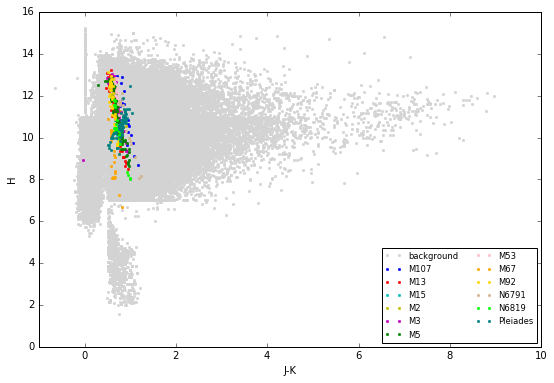

In [14]:
ap_table = ap_table.group_by('cluster_name')
k = 0
fig = plt.figure(figsize=(9,6))
plt.plot(ap_table['J']-ap_table['K'], ap_table['H'], '.', c='lightgray', 
         ms=5, label='background')
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        plt.plot(group['J']-group['K'], group['H'], '.', c=colors[k], 
                 lw=0, markersize=5, label=group['cluster_name'][0])
        k += 1
plt.xlabel('J-K')
plt.ylabel('H')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
plt.xlim(-1, 10)
plt.ylim(0,16)
plt.legend(loc=0, ncol=2, fontsize='small')
plt.savefig("C_M_all_members.png", dpi=500)
plt.show()

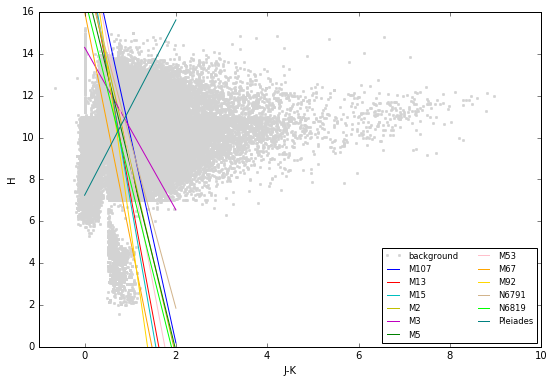

In [15]:
k = 0
fig = plt.figure(figsize=(9,6))
plt.plot(ap_table['J']-ap_table['K'], ap_table['H'], '.', c='lightgray', ms=5, label='background')
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        coeff = np.polyfit(group['J']-group['K'], group['H'], deg=1)
        poly = np.poly1d(coeff)
        xp = np.linspace(0, 2, 100)
        plt.plot(xp, poly(xp), '-', c=colors[k], markersize=5, label=group['cluster_name'][0])
        k += 1
plt.xlabel('J-K')
plt.ylabel('H')
# plt.gca().invert_yaxis()
# plt.gca().invert_xaxis()
# plt.title("Second-Order Approximation")
plt.xlim(-1, 10)
plt.ylim(0,16)
plt.legend(loc=0, ncol=2, fontsize='small')
plt.savefig("C_M_FO.png", dpi=500)
plt.show()

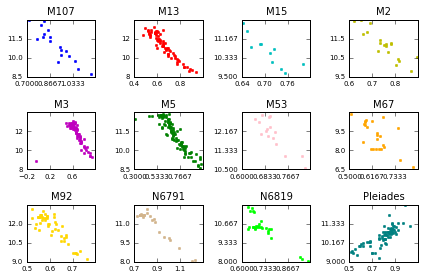

In [110]:
# f, axarr = plt.subplots(3, 4)
# x = np.arange(0,3)
# y = np.arange(0,4)
# axcorr = [[x0, y0] for x0 in x for y0 in y]
# k = 0
# for group in ap_table.groups:
#     if (group['cluster_name'][0] != 'background')&(len(group) > 10):
#         corr = axcorr[k]
#         ax = axarr[corr[0], corr[1]]
#         ax.plot(group['J']-group['K'], group['H'], '.', c=colors[k], 
#                  lw=0, markersize=5)
#         ax.set_title(group['cluster_name'][0], fontsize=10)
#         start, end = ax.get_xlim()
#         ticks = np.arange(start, end, (end-start)/3.)
#         ax.xaxis.set_ticks(ticks)
#         for tick in ax.xaxis.get_major_ticks():
#                 tick.label.set_fontsize(7) 
#                 # specify integer or one of preset strings, e.g.
#                 # tick.label.set_fontsize('x-small') 
#                 # tick.label.set_rotation('vertical')
#         start, end = ax.get_ylim()
#         ticks = np.arange(start, end, (end-start)/3.)
#         ax.yaxis.set_ticks(ticks)
#         for tick in ax.yaxis.get_major_ticks():
#                 tick.label.set_fontsize(7) 
#         k += 1
        
# fig.set_size_inches(10, 8)
# plt.tight_layout()
# plt.show()

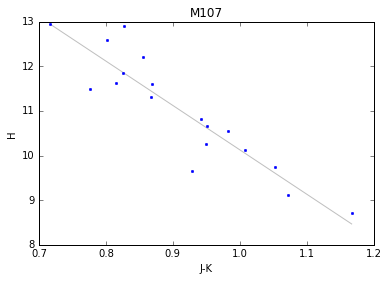

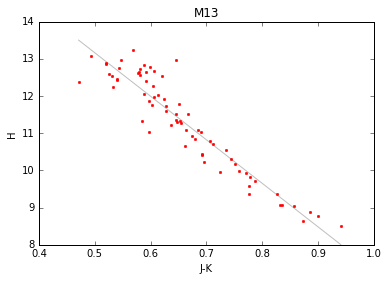

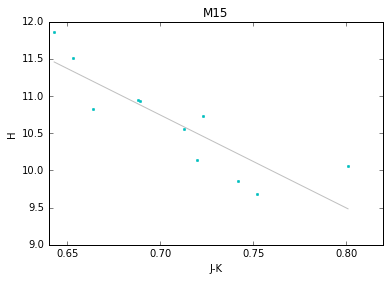

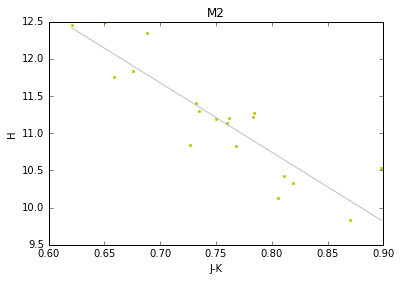

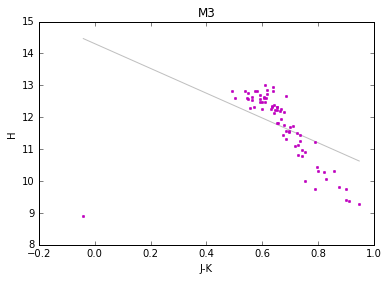

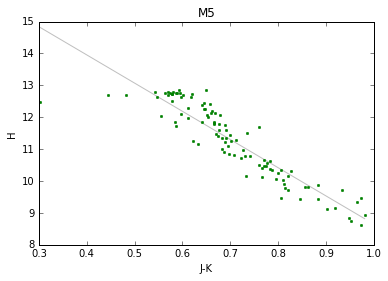

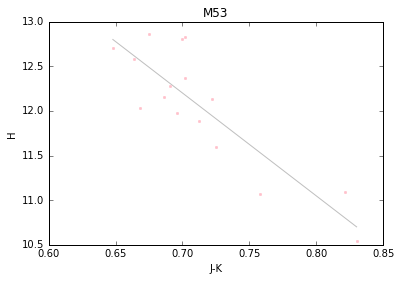

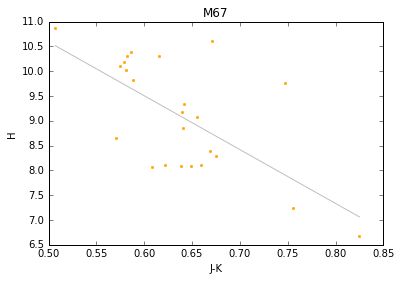

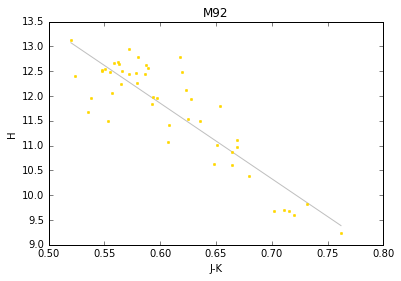

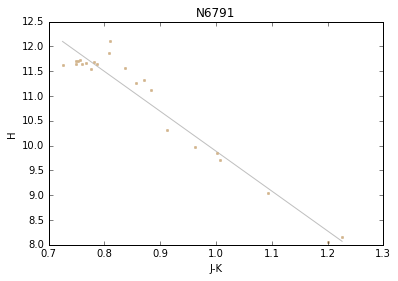

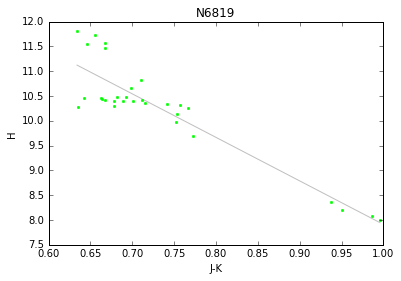

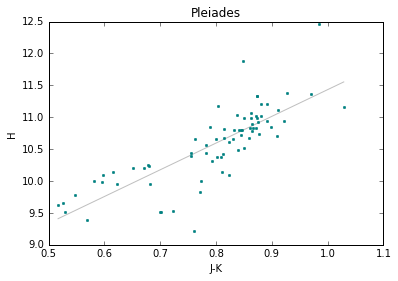

In [113]:
k = 0
for group in ap_table.groups:
    if (group['cluster_name'][0] != 'background')&(len(group) > 10):
        fig = plt.figure()
        coeff = np.polyfit(group['J']-group['K'], group['H'], deg=1)
        poly = np.poly1d(coeff)
        xp = np.linspace(np.amin(group['J']-group['K']), np.amax(group['J']-group['K']), 100)
        plt.plot(xp, poly(xp), '-', c='grey', alpha=0.5)
        plt.plot(group['J']-group['K'], group['H'], '.', c=colors[k], 
                 lw=0, markersize=5)
        k += 1
        plt.title(group['cluster_name'][0])
        plt.xlabel('J-K')
        plt.ylabel('H')
        plt.show()